# Емельянова Елизавета Всеволодовна БВТ2201

# Лабораторная работа №3: Сравнение ASR-движков (Whisper, Vosk, Giga AM) по метрикам WER/CER/RTF и оценка влияния bias prompt (контекста) в Whisper.

In [1]:
!pip -q install torchcodec jiwer evaluate torch torchaudio torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.4 MB/s eta 0:00:00


In [2]:
import librosa
import soundfile as sf
import torch
from jiwer import wer, cer
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import json

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000

Device: cuda


In [4]:
# Загрузка и ресемплинг аудио
ds = []
reference_texts = []

def process_audio_files():
    for i in range(10):
        filename = f"audio_{i+1}.wav"

        wav, sr = sf.read(filename)
        # wav = wav.astype(np.float32)

        if sr != SR:
            wav = librosa.resample(y=wav, orig_sr=sr, target=SR)

        ds.append(wav)

        with open(f"audio_{i+1}.txt", 'r', encoding='utf-8') as f:
            reference_texts.append(f.read().strip())

process_audio_files()

## Whisper

In [5]:
!pip -q install faster-whisper

In [6]:
from faster_whisper import WhisperModel

model = WhisperModel("base", device="cuda", compute_type="float16")
results_whisper = []

for i, audio in enumerate(ds):
    temp_filename = f"temp_audio_{i}.wav"
    sf.write(temp_filename, audio, SR)

    start_time = time.time()
    segments, _ = model.transcribe(temp_filename)
    text = " ".join([segment.text for segment in segments])
    end_time = time.time()

    audio_duration = len(audio) / SR
    processing_time = end_time - start_time

    results_whisper.append({
        'audio': f'audio_{i + 1}',
        'reference': reference_texts[i],
        'predicted': text,
        'wer': wer(reference_texts[i], text),
        'cer': cer(reference_texts[i], text),
        'rtf': processing_time / audio_duration,
        'processing_time': processing_time
    })

    if os.path.exists(temp_filename):
        os.remove(temp_filename)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


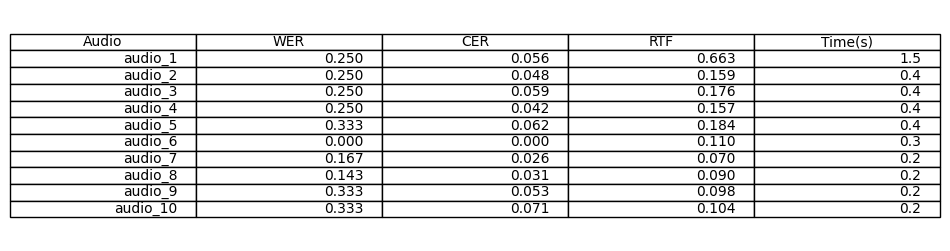

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

data = [[r['audio'], f"{r['wer']:.3f}", f"{r['cer']:.3f}", f"{r['rtf']:.3f}", f"{r['processing_time']:.1f}"]
        for r in results_whisper]

table = ax.table(cellText=data,
                colLabels=['Audio', 'WER', 'CER', 'RTF', 'Time(s)'],
                loc='center')

plt.show()

## Vosk

In [8]:
!pip -q install vosk

In [9]:
from vosk import Model, KaldiRecognizer

model = Model(lang="en-us")
results_vosk = []

for i, audio in enumerate(ds):
    rec = KaldiRecognizer(model, SR)

    audio_int16 = (audio * 32767).astype(np.int16)

    start_time = time.time()

    text_parts = []
    chunk_size = 4000

    for j in range(0, len(audio_int16), chunk_size):
        chunk = audio_int16[j:j+chunk_size]
        if len(chunk) == 0:
            continue

        if rec.AcceptWaveform(chunk.tobytes()):
            result = json.loads(rec.Result())
            if result.get('text'):
                text_parts.append(result['text'])

    final_result = json.loads(rec.FinalResult())
    if final_result.get('text'):
        text_parts.append(final_result['text'])

    predicted_text = " ".join(text_parts).strip()
    end_time = time.time()

    processing_time = end_time - start_time
    audio_duration = len(audio) / SR

    results_vosk.append({
        'audio': f'audio_{i+1}',
        'reference': reference_texts[i],
        'predicted': predicted_text,
        'wer': wer(reference_texts[i], predicted_text),
        'cer': cer(reference_texts[i], predicted_text),
        'rtf': processing_time / audio_duration,
        'processing_time': processing_time
    })

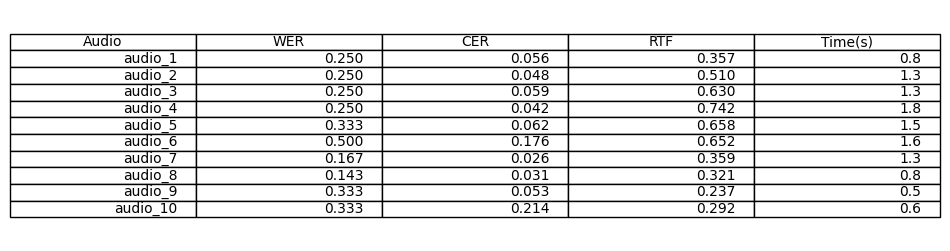

In [10]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

data = [[r['audio'], f"{r['wer']:.3f}", f"{r['cer']:.3f}", f"{r['rtf']:.3f}", f"{r['processing_time']:.1f}"]
        for r in results_vosk]

table = ax.table(cellText=data,
                colLabels=['Audio', 'WER', 'CER', 'RTF', 'Time(s)'],
                loc='center')

plt.show()

## Giga AM

In [11]:
!git clone https://github.com/salute-developers/GigaAM.git
%cd GigaAM

!pip install -e .

fatal: destination path 'GigaAM' already exists and is not an empty directory.
/content/GigaAM
Obtaining file:///content/GigaAM
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gigaam
    Found existing installation: gigaam 0.1.0
    Uninstalling gigaam-0.1.0:
      Successfully uninstalled gigaam-0.1.0
  Running setup.py develop for gigaam


In [12]:
import gigaam
model = gigaam.load_model("ctc")
print(model)

100%|███████████████████████████████████████| 444M/444M [00:28<00:00, 16.4MiB/s]
/content/GigaAM/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkp

GigaAMASR(
  (preprocessor): FeatureExtractor(
    (featurizer): Sequential(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): SpecScaler()
    )
  )
  (encoder): ConformerEncoder(
    (pre_encode): StridingSubsampling(
      (out): Linear(in_features=12288, out_features=768, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(768, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
      )
    )
    (pos_enc): RotaryPositionalEmbedding()
    (layers): ModuleList(
      (0-15): 16 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (activation): SiLU()
          (linear2): Linear(in_features=3072, out_features=768, bi

In [13]:
results_gigaam = []

for i, audio in enumerate(ds):
    temp_filename = f"/content/temp_audio_{i}.wav"
    sf.write(temp_filename, audio, SR)

    start_time = time.time()
    transcription = model.transcribe(temp_filename)
    end_time = time.time()

    audio_duration = len(audio) / SR
    processing_time = end_time - start_time

    results_gigaam.append({
        'audio': f'audio_{i + 1}',
        'reference': reference_texts[i],
        'predicted': transcription,
        'wer': wer(reference_texts[i], transcription),
        'cer': cer(reference_texts[i], transcription),
        'rtf': processing_time / audio_duration,
        'processing_time': processing_time
    })

    if os.path.exists(temp_filename):
        os.remove(temp_filename)


/content/GigaAM/gigaam/preprocess.py:40: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  return torch.frombuffer(audio, dtype=torch.int16).float() / 32768.0


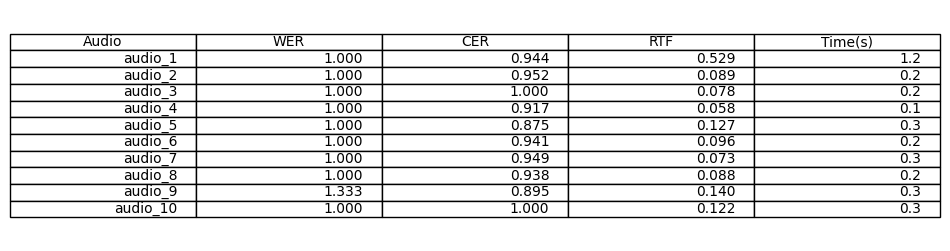

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

data = [[r['audio'], f"{r['wer']:.3f}", f"{r['cer']:.3f}", f"{r['rtf']:.3f}", f"{r['processing_time']:.1f}"]
        for r in results_gigaam]

table = ax.table(cellText=data,
                colLabels=['Audio', 'WER', 'CER', 'RTF', 'Time(s)'],
                loc='center')

plt.show()

In [15]:
%cd ..

/content


### Оценка влияния bias prompt (контекста) в Whisper

In [21]:
# Загрузка и ресемплинг аудио
ds_terms = []
reference_texts_terms = []

def process_audio_files():
    for i in range(5):
        filename = f"audio_terms_{i+1}.wav"

        wav, sr = sf.read(filename)
        # wav = wav.astype(np.float32)

        if sr != SR:
            wav = librosa.resample(y=wav, orig_sr=sr, target_sr=SR)

        ds_terms.append(wav)

        with open(f"audio_terms_{i+1}.txt", 'r', encoding='utf-8') as f:
            reference_texts_terms.append(f.read().strip())

process_audio_files()

In [25]:
from faster_whisper import WhisperModel

model = WhisperModel("base", device="cuda", compute_type="float16")
results_whisper_prompt = []

domain_prompt = """
Это аудио содержит технические термины связанные с доменами и DNS:
доменные имена, wildcard, DNS записи, DNS серверы, хосты, веб-сервер, WHOIS,
CDN, CNAME записи, поддомены, провайдер, трафик, IP адреса, геолокационный роутинг,
Anycast сети, балансировку, мониторинг, lookup проверки, TTL,
делегирование, трансфер доменов, IDN, Anycast.
"""


for i, audio in enumerate(ds_terms):
    temp_filename = f"temp_audio_{i}.wav"
    sf.write(temp_filename, audio, SR)

    segments, _ = model.transcribe(temp_filename, language='ru')
    text = " ".join([segment.text for segment in segments])

    segments_prompt, _ = model.transcribe(temp_filename, language='ru', initial_prompt=domain_prompt)
    text_prompt = " ".join([segment.text for segment in segments_prompt])

    results_whisper_prompt.append({
        'audio': f'audio_{i + 1}',
        'wer_no_prompt': wer(reference_texts_terms[i], text),
        'cer_no_prompt': cer(reference_texts_terms[i], text),
        'wer_with_prompt': wer(reference_texts_terms[i], text_prompt),
        'cer_with_prompt': cer(reference_texts_terms[i], text_prompt),
    })

    if os.path.exists(temp_filename):
        os.remove(temp_filename)

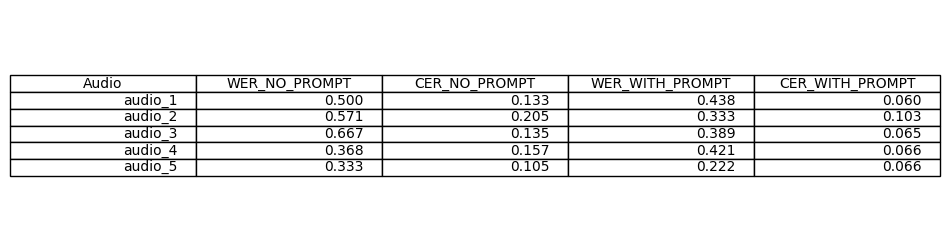

In [26]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

data = [[r['audio'], f"{r['wer_no_prompt']:.3f}", f"{r['cer_no_prompt']:.3f}",  f"{r['wer_with_prompt']:.3f}", f"{r['cer_with_prompt']:.3f}"]
        for r in results_whisper_prompt]

table = ax.table(cellText=data,
                colLabels=['Audio', 'WER_NO_PROMPT', 'CER_NO_PROMPT', 'WER_WITH_PROMPT', 'CER_WITH_PROMPT'],
                loc='center')

plt.show()